deeper FF models have slightly worse performance than recurrent.

In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product, chain

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
# I forgot how this count_params handles BN buffer parameters (running mean and std) looks like it's ignored.
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished_with_rcnn_k_bl.builder import load_modules

load_modules()

In [4]:
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200704 as param_iterator_obj_1,
#     explored_models_20200705 as param_iterator_obj_2,
    explored_models_20200530_2 as param_iterator_obj_deeper_ff,
    keygen
)

In [5]:
# compute ccmax
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)

In [6]:
def load_everything():
    _df_collect = []
    for idx, param in enumerate(
        chain(
            param_iterator_obj_1().generate(),
#             param_iterator_obj_2().generate(),
            param_iterator_obj_deeper_ff().generate(),
        )
    ):
        if idx % 100 == 0:
            print(idx)
            
#         if idx >= 100:
#             break
            
#         print(len(param))
#         print(len(param))

        if param['kernel_size_l23'] != 3:
            continue

        if len(param) == 22:
            param['train_keep'] = None
        assert len(param) == 23
        
        assert param['kernel_size_l1'] == 9
        assert param['ff_1st_block']
        
        
        
        assert param['split_seed'] == 'legacy'
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        assert not param['bn_after_fc']
        assert param['rcnn_bl_psize'] == 1
        assert param['rcnn_bl_ptype'] is None
        assert param['input_size'] == 50
        
        if param['rcnn_bl_cls'] == 1:
            assert param['rcnn_acc_type'] in {'cummean', 'cummean_last'}
        else:
            assert param['rcnn_acc_type'] == 'cummean_last'
        
        # 12 to go
        # remove smoothness_name and scale_name, 10 to go
        
#         assert param['model_seed'] == 0
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (79,)
        
        if param['train_keep'] is None:
            param['train_keep'] = 5120
        
        _df_collect.append(
            {
                'train_keep': param['train_keep'],
                'act_fn': param['act_fn'],
                'loss_type': param['loss_type'],
                'scale': float(param['scale']),
                'smoothness': float(param['smoothness']),
                'num_layer': param['num_layer'],
                'out_channel': param['out_channel'],
                # 4 to go.
                '1st_bn_before_act': param['ff_1st_bn_before_act'],
                'rcnn_bl_cls': param['rcnn_bl_cls'],
#                 'rcnn_acc_type': param['rcnn_acc_type'],

                'model_seed': param['model_seed'],
                # done,
                'corr_test': ((cc_raw/cc_max_all_neurons)**2).mean(),
                'max_epoch': max(num_epochs),
                'num_param': count_params(result['model']),
            }
        )
    _df =  pd.DataFrame(_df_collect, columns=[
#             'split_seed',
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',

        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',

        'corr_test',
        'num_param',
        'max_epoch',
    ])
#     print(_df)
    _df = _df.set_index([
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',
        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',
    ], verify_integrity=True)
    return _df

In [7]:
df = load_everything()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


In [8]:
corr_mean = df['corr_test'].unstack('model_seed').mean(axis=1)

# mean, max, min, all the same. for num_param
num_param = df['num_param'].unstack('model_seed').mean(axis=1)

training size 1280


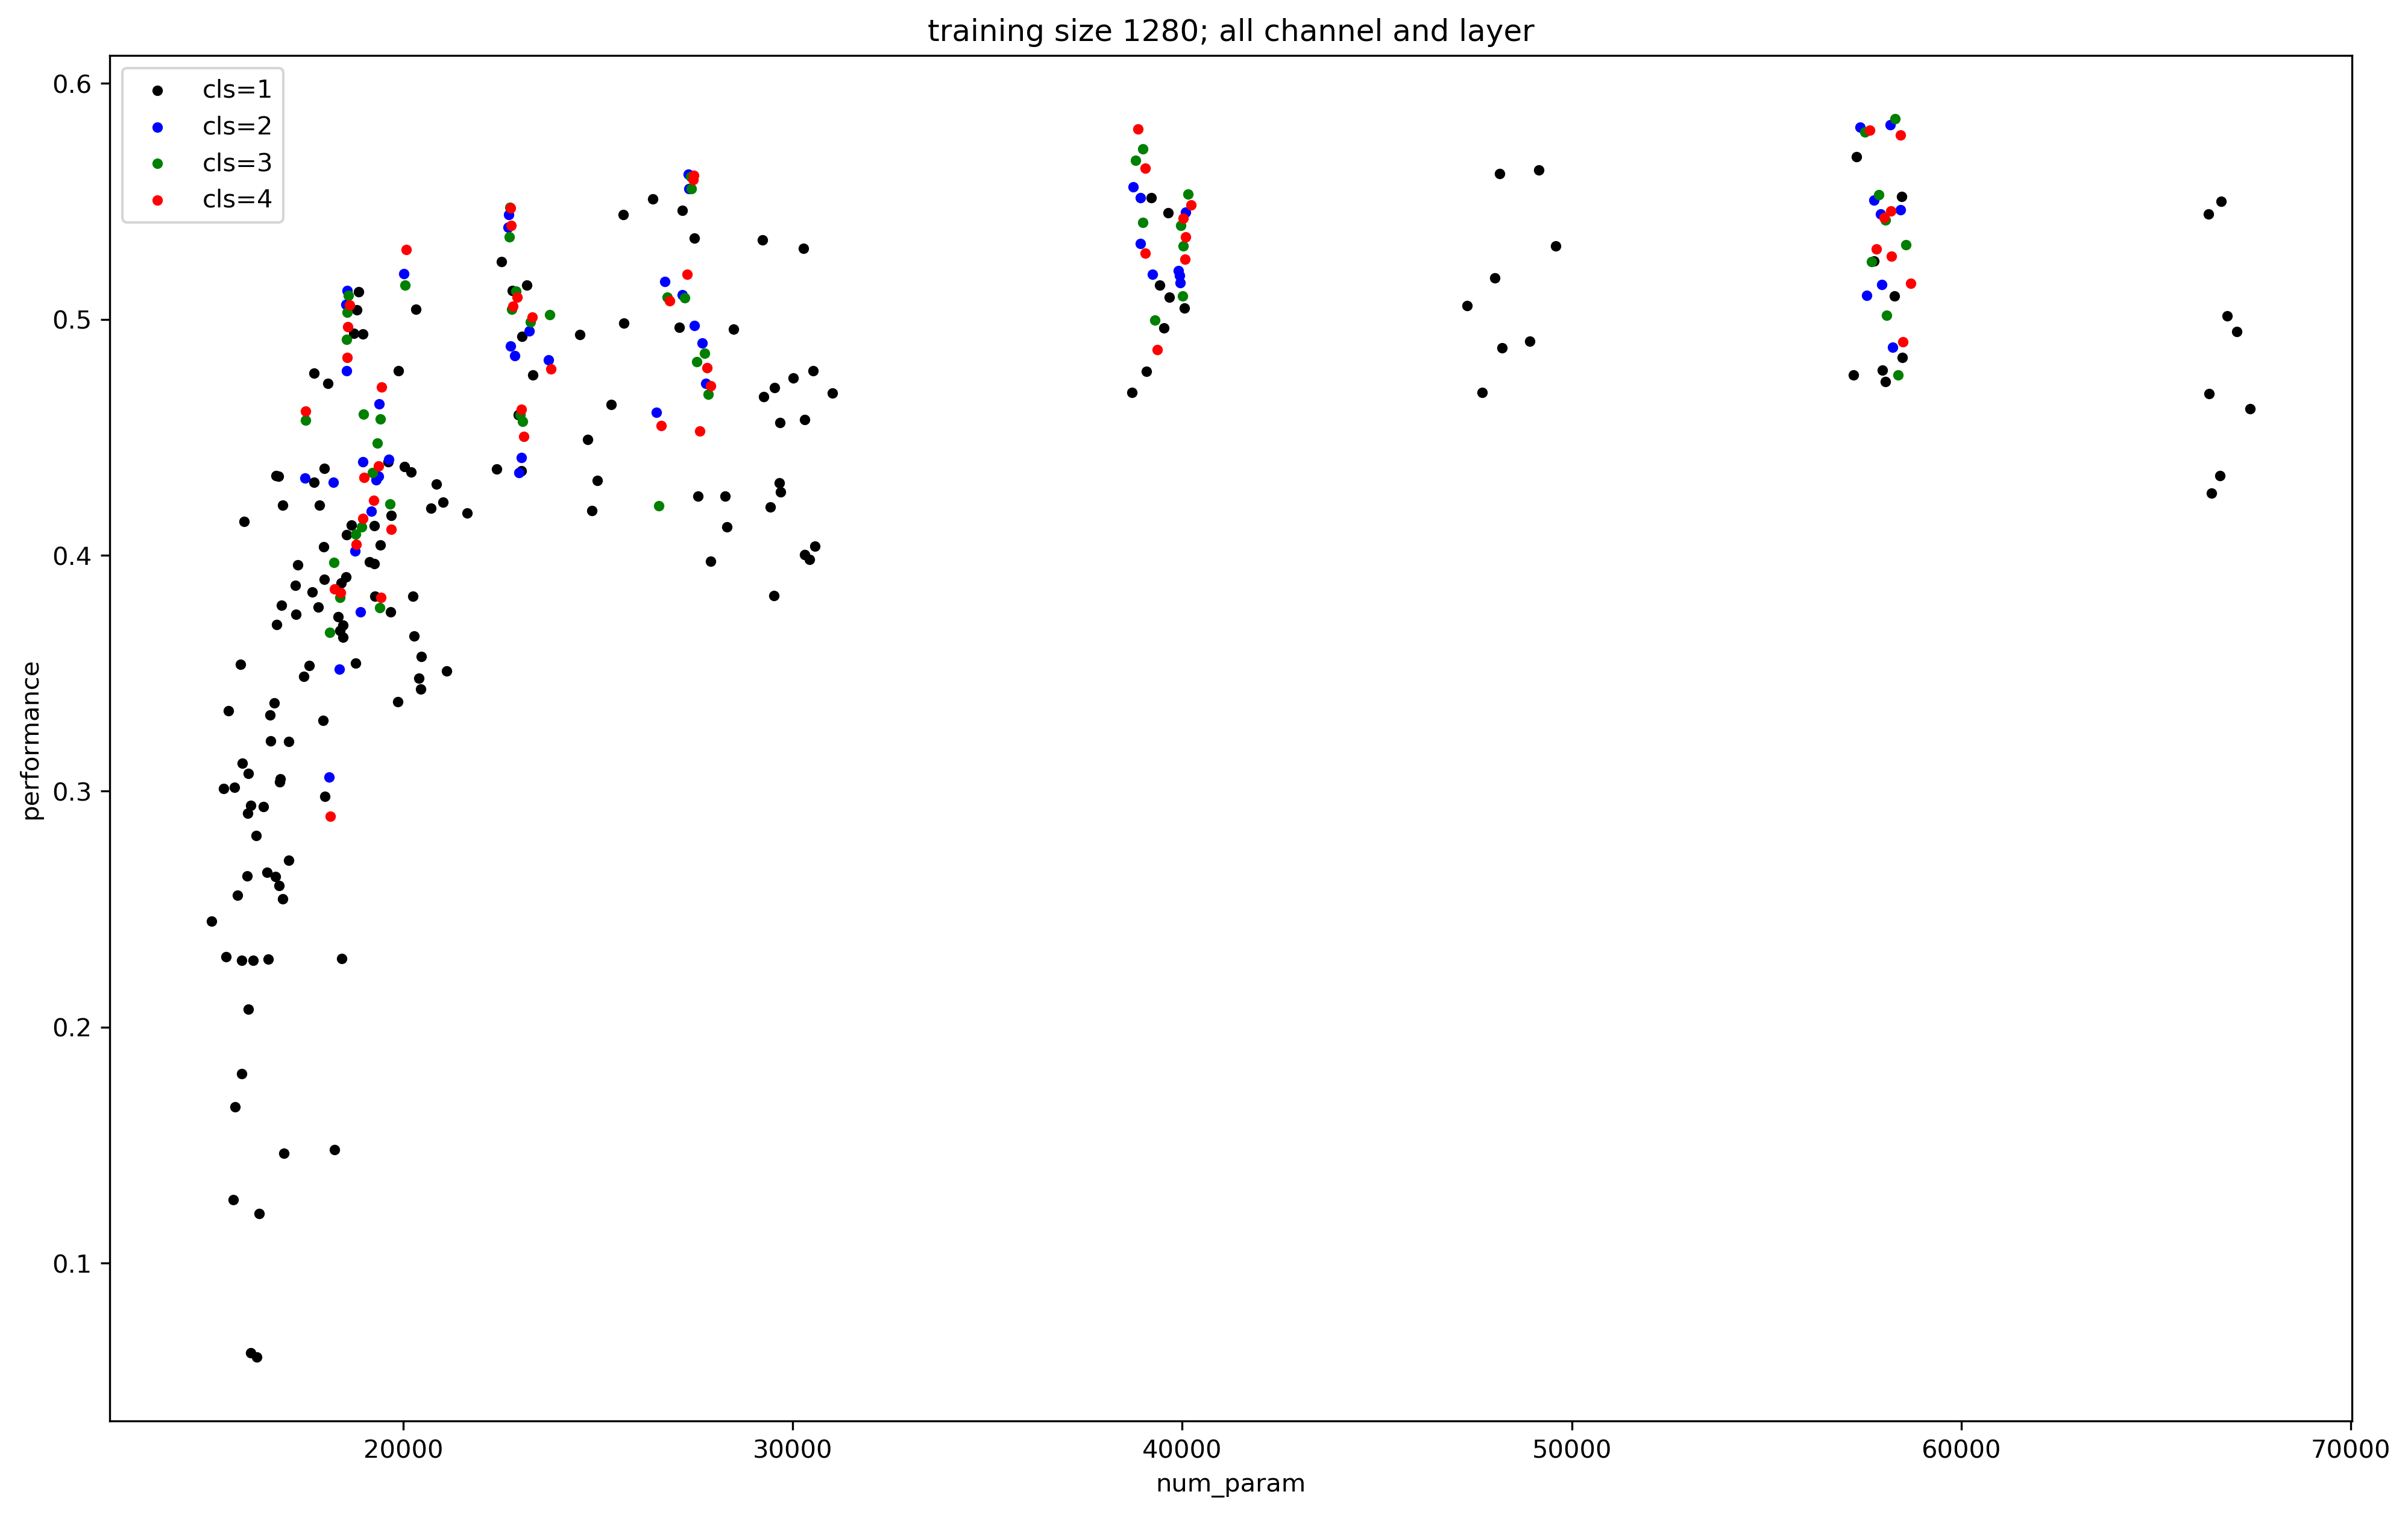

training size 2560


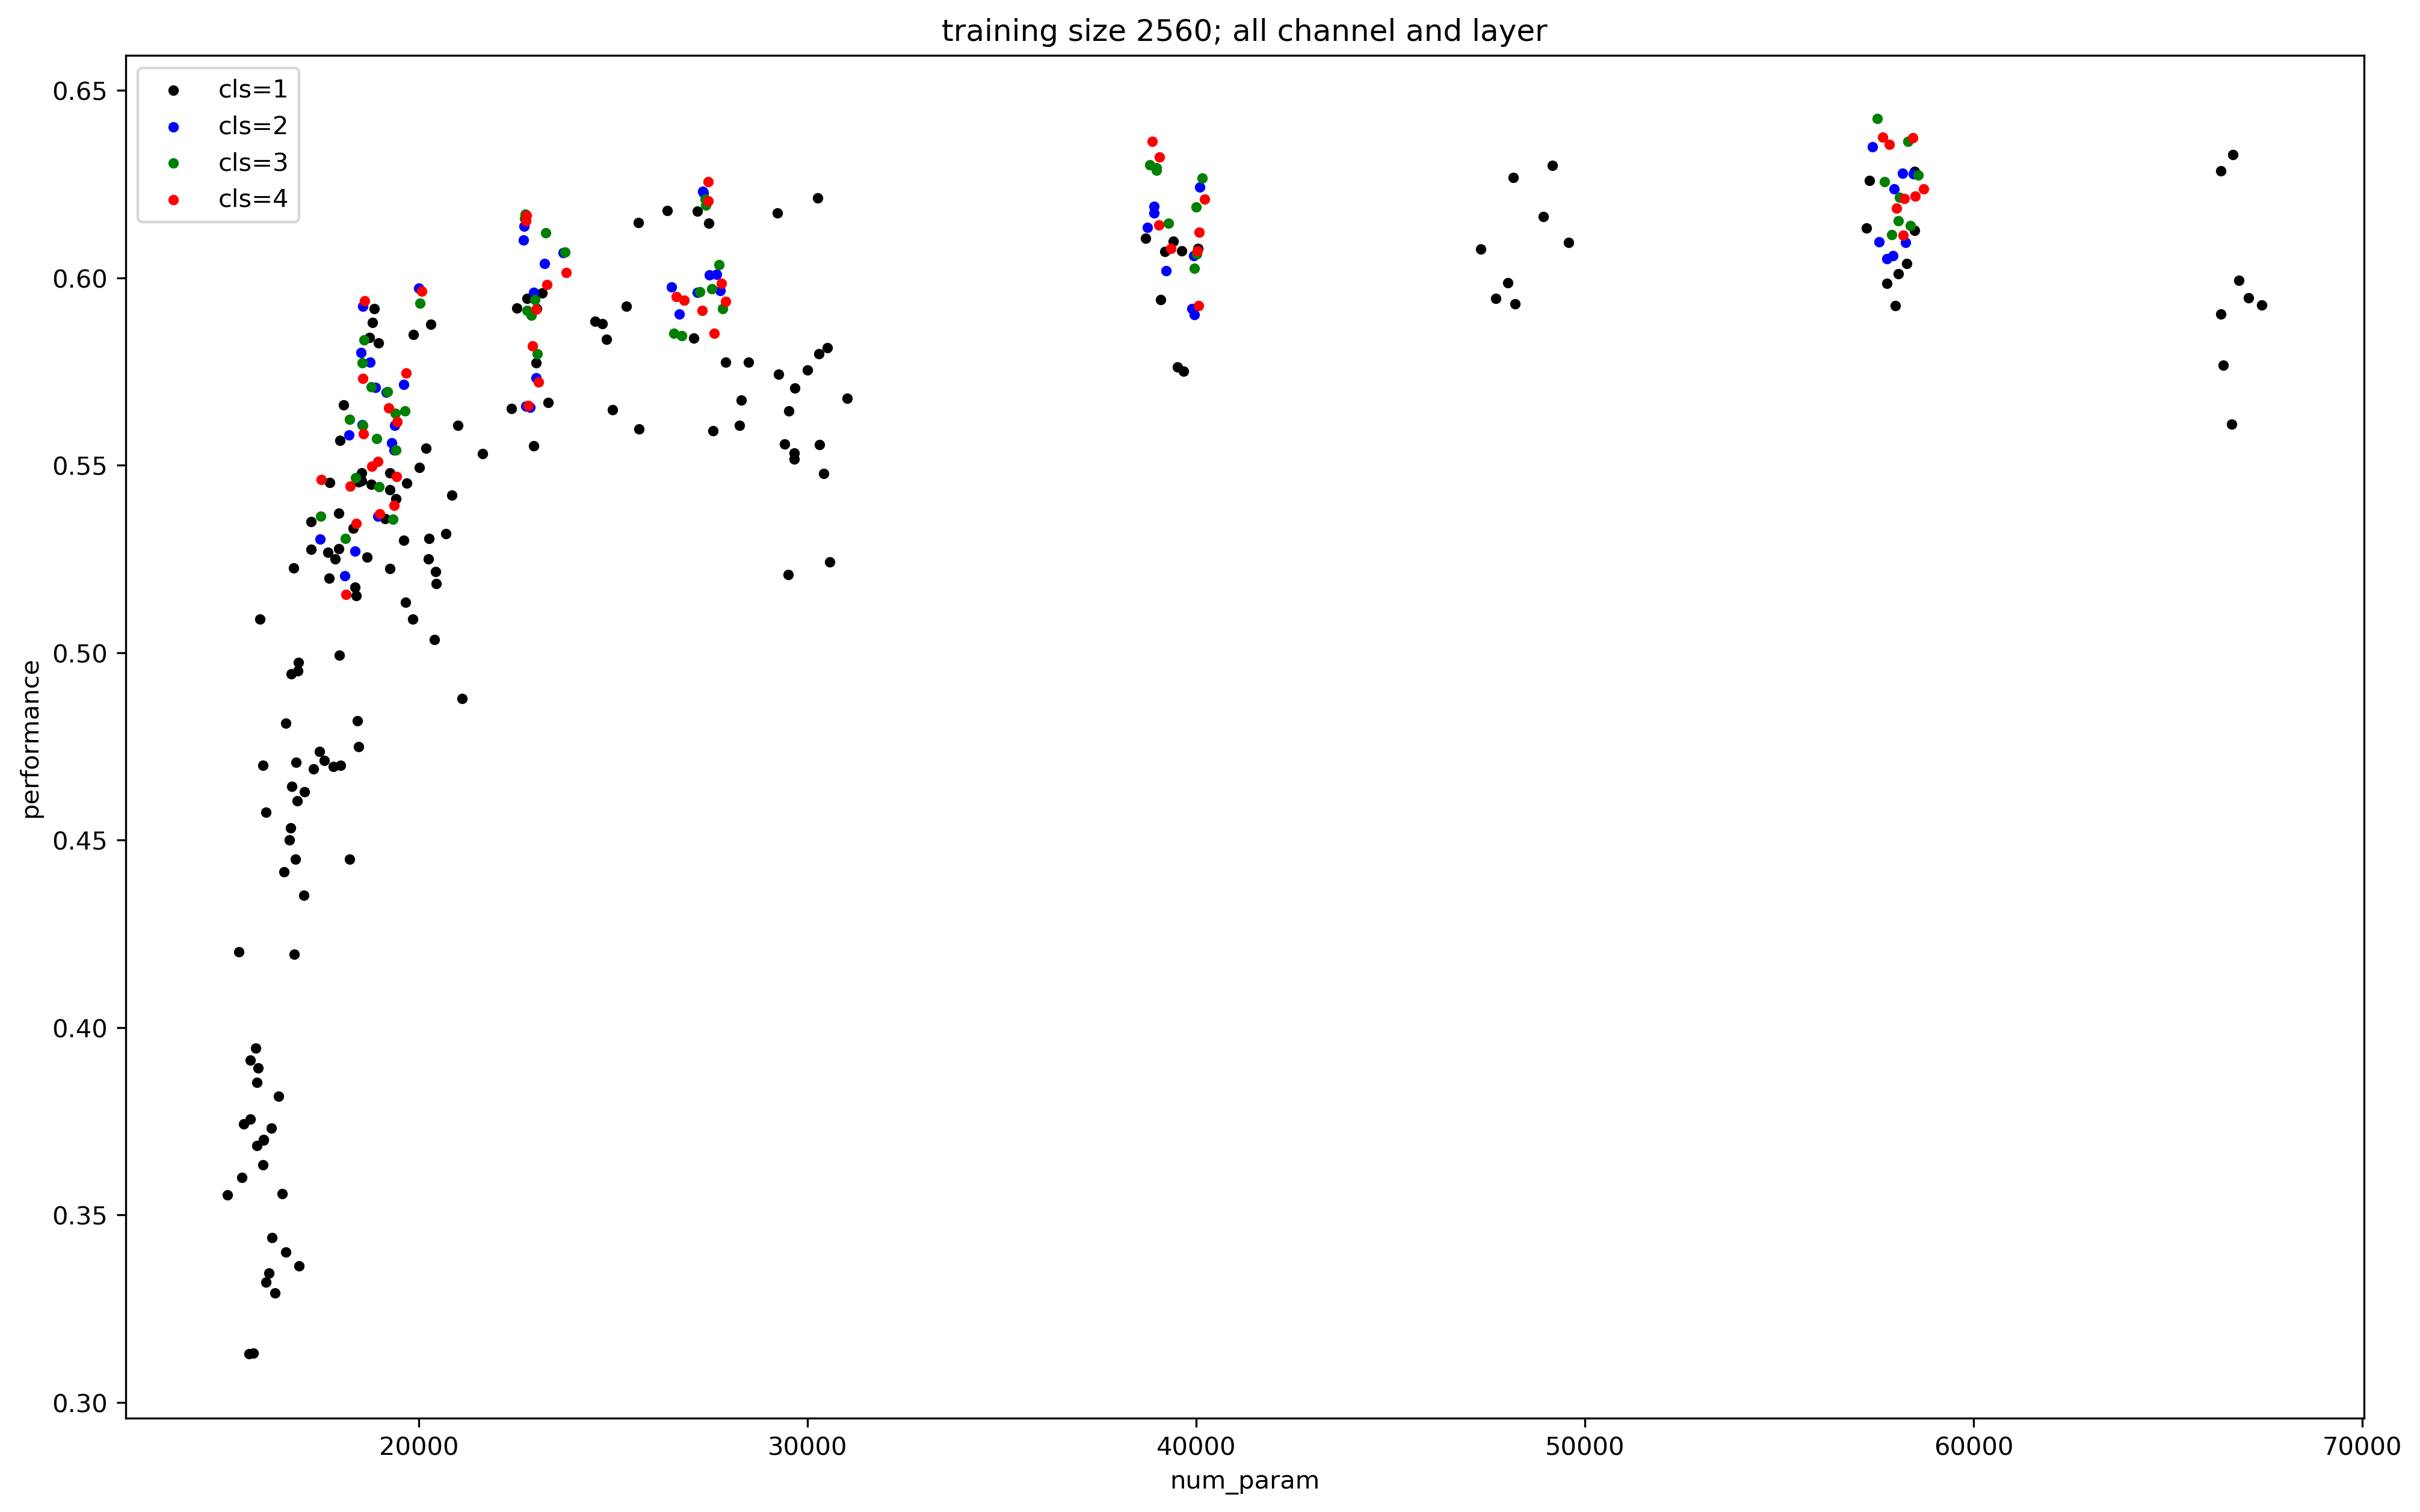

training size 5120


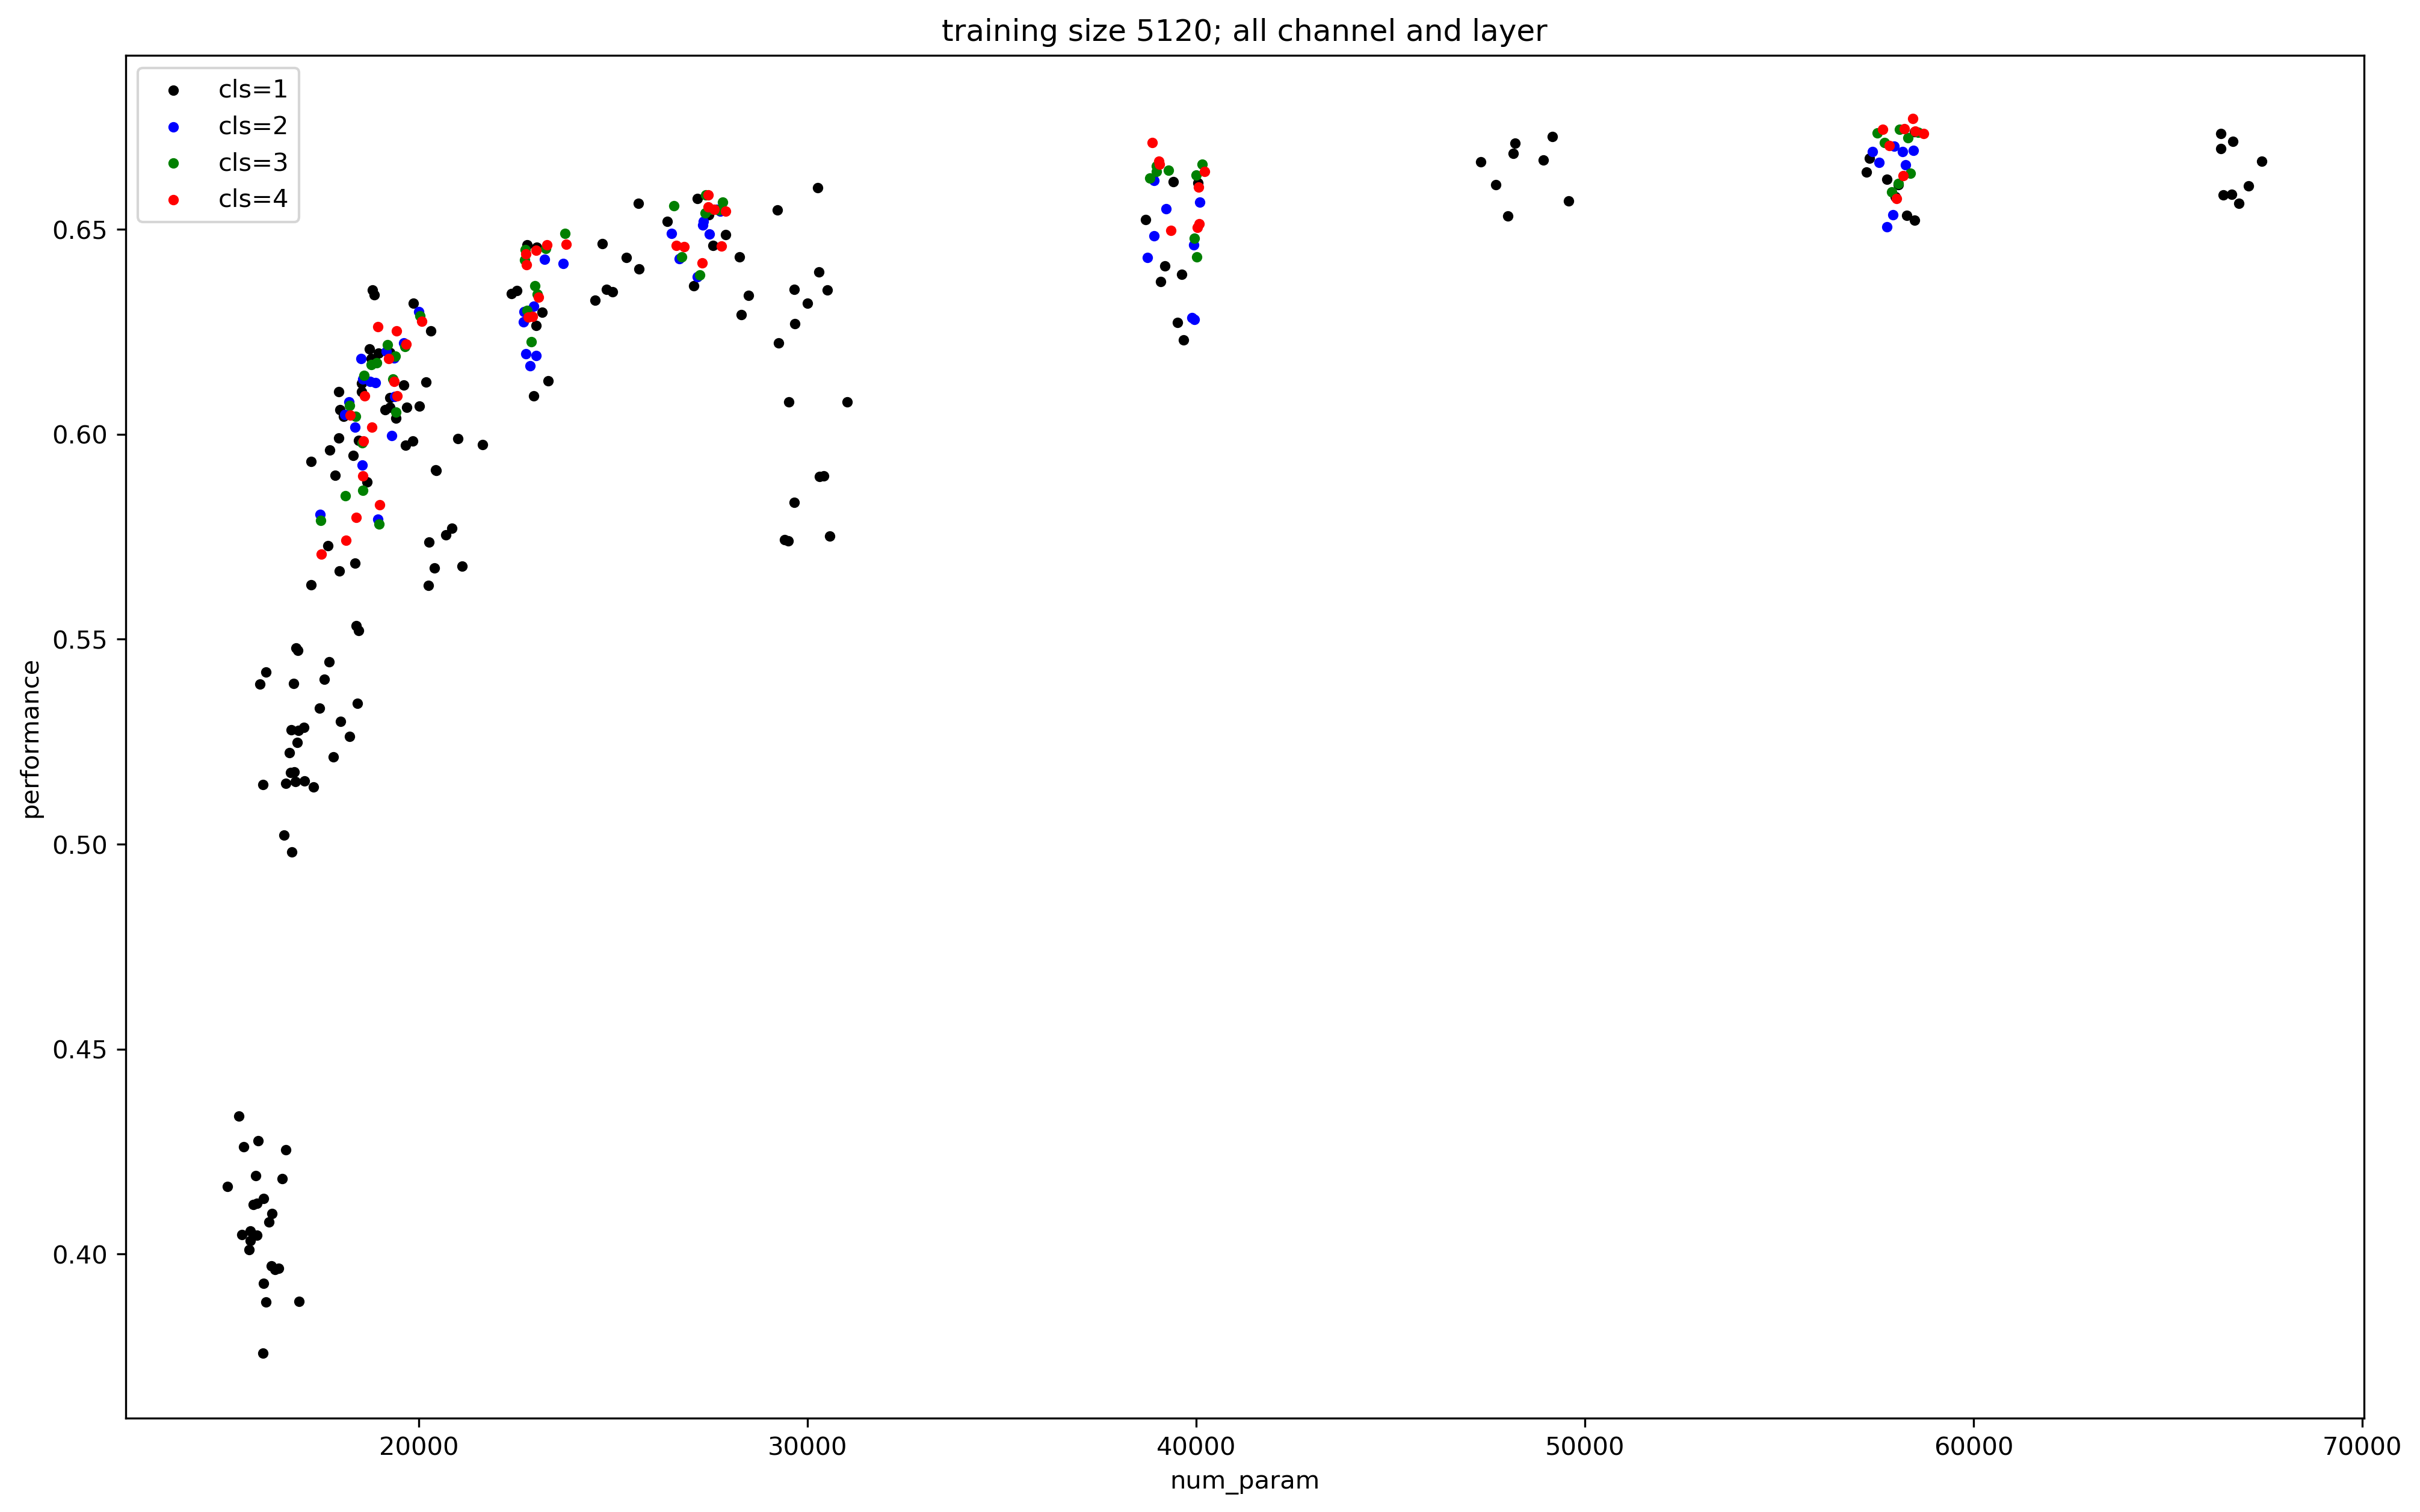

In [9]:
def check_relationship_between_num_param_and_perf_given_different_cycle(corr_mean_this, num_param_this, second_level, title_suffix):
    assert corr_mean_this.shape == num_param_this.shape
    assert corr_mean_this.index.equals(num_param_this.index)
    corr_mean_local = corr_mean_this.rename('corr_mean')
    num_param_local = num_param_this.rename('num_param')
    
    # combine them.
    df_to_check = pd.concat([corr_mean_local, num_param_local], axis=1)
    
    training_sizes = df_to_check.index.get_level_values('train_keep').unique()
    
    
    for training_size_this in training_sizes:
        print('training size', training_size_this)
        check_relationship_between_num_param_and_perf_given_different_cycle_inner(
            df_to_check.xs(training_size_this, level='train_keep'),
            title=f'training size {training_size_this}; {title_suffix}',
            second_level=second_level,
        )

def rand_jitter(arr, seed=0):
    rng_state = np.random.RandomState(seed=seed)
    stdev = .01*(max(arr)-min(arr))
    return arr + rng_state.randn(*arr.shape) * stdev
    return arr
        
def check_relationship_between_num_param_and_perf_given_different_cycle_inner(df_to_check, title, second_level):
    cycle_list = df_to_check.index.get_level_values('rcnn_bl_cls').unique()
    if second_level is not None:
        layer_list = df_to_check.index.get_level_values(second_level).unique()
    else:
        layer_list = [None]
    color_list = ['k', 'b', 'g', 'r']
    marker_list = ['o', 'D', '*']
    assert len(color_list) >= len(cycle_list)
    assert len(marker_list) >= len(layer_list)
    plt.close('all')
    plt.figure(figsize=(16, 10), dpi=300)
    
    for c, color in zip(cycle_list, color_list):
        for num_l, marker in zip(layer_list, marker_list):
            data_this = df_to_check.xs(c, level='rcnn_bl_cls')
            if second_level is not None:
                data_this=data_this.xs(num_l, level=second_level)
            plt.scatter(
                # jitter num_param so that I can tell dots apart
                rand_jitter(data_this['num_param'].values),
                data_this['corr_mean'].values,
                s=10,
                marker=marker,
                c=color,
                label=f'cls={c}, {second_level}={num_l}' if second_level is not None else f'cls={c}',
            )
    
    plt.legend(loc='best')
#     plt.xlim(0,1)
#     plt.ylim(0,1)
#     plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.xlabel('num_param')
    plt.ylabel('performance')
    
    
    plt.show()

check_relationship_between_num_param_and_perf_given_different_cycle(corr_mean, num_param,
                                                                   second_level=None, title_suffix='all channel and layer')
# with similar number of parameters, I think definitely more cycles can lead to better results.

In [10]:
# get more quantitive measures. this is necessary for publication.
# I will check each num layer x num channel combinations for cls=1
# and then check cls > 1, num_layer -1 models.

In [11]:
combined_df = pd.concat([corr_mean, num_param], axis=1).rename(columns={0:'corr_mean', 1:'num_param'})

In [12]:
assert combined_df.index.equals(corr_mean.index)
assert combined_df.index.equals(num_param.index)

In [13]:
def get_quantitive_measures_outer_one_case(values):
    assert isinstance(values, np.ndarray) and values.ndim == 1
    return {
        'p25': np.percentile(values, 25),
        'p50': np.percentile(values, 50),
        'p75': np.percentile(values, 75),
        'mean': values.mean(),
        'sem': values.std()/np.sqrt(values.size),
    }

In [14]:
def quantitive_measures_outer(df_this):
    # first get all possible combinations of layer and channel, for cls = 1
    
    cls_1_df = df_this.xs(1, level='rcnn_bl_cls')
    
    cls_1_layers = cls_1_df.index.get_level_values('num_layer')
    cls_1_channels = cls_1_df.index.get_level_values('out_channel')
    cls_1_data_combined = np.asarray([cls_1_layers.values, cls_1_channels.values]).T
    cls_1_layer_c_unique = np.unique(cls_1_data_combined, axis=0)
    print(cls_1_layer_c_unique)
    
    # ok, for each one I will see if there is some cls>1 models to compare with.
    cls_high_df = df_this.loc[df_this.index.get_level_values('rcnn_bl_cls') != 1]
    
    print(cls_1_df.shape, cls_high_df.shape)
    
    df_to_collect = []
    
    for (num_layer_this, num_ch_this) in cls_1_layer_c_unique:
        print(num_layer_this, num_ch_this)
        model_1c = cls_1_df.xs(num_layer_this, level='num_layer').xs(num_ch_this, level='out_channel')
        print(model_1c.shape)
        
        if num_layer_this % 2 == 0:
            print('no matching models!')
            continue
        
        num_layer_high_c = (num_layer_this-1)//2 + 1
        
        if num_layer_high_c not in cls_high_df.index.get_level_values('num_layer'):
            print('no matching models!')
            continue
        
        cls_high_df_matched_layer = cls_high_df.xs(num_layer_high_c, level='num_layer')
        if num_ch_this not in cls_high_df_matched_layer.index.get_level_values('out_channel'):
            print('no matching models!')
            continue
            
        cls_high_df_matched_both = cls_high_df_matched_layer.xs(num_ch_this, level='out_channel')
        print(cls_high_df_matched_both.shape)
        
        
#         model_high_c = df_this.xs(num_layer_this-1, level='num_layer').xs(num_ch_this, level='out_channel')
#         model_high_c = model_high_c.loc[model_high_c.index.get_level_values('rcnn_bl_cls')!=1]
#         print(model_high_c.shape)

        # collect num_param
        num_param_l1_models = model_1c['num_param'].values
        print(num_param_l1_models)
        
        num_param_l_high_models = cls_high_df_matched_both['num_param'].values
        print(num_param_l_high_models)
        
        # insert layer 1 cases.
        # for corr, check p25, p50, p75, mean, std
        shared_part = {
                'num_layer_ff': num_layer_this,
                'num_layer_recurrent': num_layer_high_c,
                'num_ch': num_ch_this,
            }
        
        df_to_collect.append(
            {
            **shared_part,
                **{
                  'cls': 1,  
                },
                **get_quantitive_measures_outer_one_case(
                    model_1c['corr_mean'].values,
                ),
                **{
                    'num_param_mean': num_param_l1_models.mean(),
                }
            }
        )
        
        # get data for cls>1
        for cls_this_one in cls_high_df_matched_both.index.get_level_values('rcnn_bl_cls').unique():
            df_to_collect.append(
            {
            **shared_part,
                **{
                  'cls': cls_this_one,  
                },
                **get_quantitive_measures_outer_one_case(
                    cls_high_df_matched_both.xs(cls_this_one, level='rcnn_bl_cls')['corr_mean'].values,
                ),
                **{
                    'num_param_mean': cls_high_df_matched_both.xs(cls_this_one, level='rcnn_bl_cls')['num_param'].values.mean(),
                }
            }
        )
    df_to_collect = pd.DataFrame(df_to_collect, columns=list(df_to_collect[0].keys()))
    df_to_collect = df_to_collect.set_index(keys=list(shared_part.keys()) + ['cls',], verify_integrity=True)
    return df_to_collect

In [15]:
# let's plot this, p50, mean, and num_param_mean
# on x axis I want to show all labels.

In [16]:
def plot_df_quant_one(data_this, index_ref, title_this, yerr=None):
    data_this = data_this.sort_index()
    assert data_this.index.equals(index_ref)
    
    if yerr is not None:
        yerr = yerr.sort_index()
        assert yerr.index.equals(index_ref)
    
    plt.close('all')
    data_this.plot(figsize=(12,6), title=title_this, linestyle='None', marker='*', yerr=yerr)
    plt.show()
    

def plot_df_quant(df_quant_this):
    index_ref = df_quant_this['p50'].unstack('cls').sort_index().index
    print(index_ref)
    # plot num_param
    plot_df_quant_one(df_quant_this['num_param_mean'].unstack('cls'), index_ref, 'num_param_mean')
    
    # p50
    plot_df_quant_one(df_quant_this['p50'].unstack('cls'), index_ref, 'neural prediction p50')
    
    # mean
    plot_df_quant_one(df_quant_this['mean'].unstack('cls'), index_ref, 'neural prediction mean')
    
    
    # mean with sem
    
    plot_df_quant_one(df_quant_this['mean'].unstack('cls'), index_ref, 'neural prediction mean + sem',
                     df_quant_this['sem'].unstack('cls'))

In [17]:

def plot_all_quant():
    for training_size in combined_df.index.get_level_values('train_keep').unique():
        print('training size', training_size)
        measure_df_quant = quantitive_measures_outer(combined_df.xs(training_size, level='train_keep'))
        plot_df_quant(measure_df_quant)
# one can argue that, increasing # of parameter via recurrent is more
# EFFICIENT than via having more layers.

# efficient in terms of performance1/performance2 vs num_param1/num_param2.

# basically, how much performance can, can each unit of parameter increase provide.


# note that the gap between recurrent and FF is bigger with SMALLER training data.
# consistent with the idea that recurrent is a useful prior.

training size 1280
[[ 2  8]
 [ 2 16]
 [ 2 32]
 [ 3  8]
 [ 3 16]
 [ 3 32]
 [ 4  2]
 [ 4  4]
 [ 4  8]
 [ 4 16]
 [ 4 32]
 [ 5  2]
 [ 5  4]
 [ 5  8]
 [ 5 16]
 [ 5 32]
 [ 6  2]
 [ 6  4]
 [ 6  8]
 [ 6 16]
 [ 6 32]]
(168, 2) (144, 2)
2 8
(8, 2)
no matching models!
2 16
(8, 2)
no matching models!
2 32
(8, 2)
no matching models!
3 8
(8, 2)
(24, 2)
[18053. 18045. 18053. 18045. 18053. 18045. 18053. 18045.]
[18053. 18069. 18085. 18045. 18061. 18077. 18053. 18069. 18085. 18045.
 18061. 18077. 18053. 18069. 18085. 18045. 18061. 18077. 18053. 18069.
 18085. 18045. 18061. 18077.]
3 16
(8, 2)
(24, 2)
[22845. 22829. 22845. 22829. 22845. 22829. 22845. 22829.]
[22845. 22877. 22909. 22829. 22861. 22893. 22845. 22877. 22909. 22829.
 22861. 22893. 22845. 22877. 22909. 22829. 22861. 22893. 22845. 22877.
 22909. 22829. 22861. 22893.]
3 32
(8, 2)
(24, 2)
[39341. 39309. 39341. 39309. 39341. 39309. 39341. 39309.]
[39341. 39405. 39469. 39309. 39373. 39437. 39341. 39405. 39469. 39309.
 39373. 39437. 39341. 39405. 3

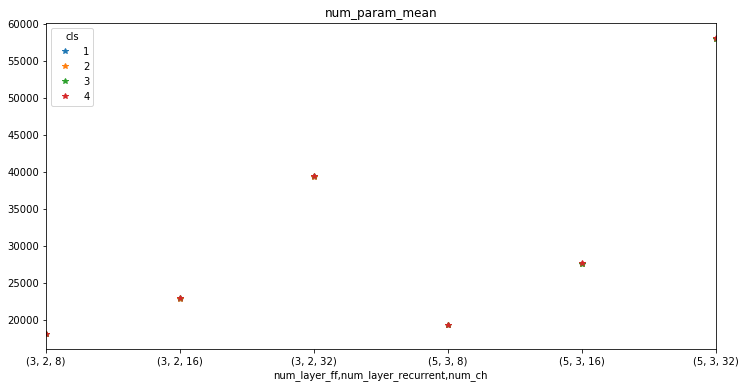

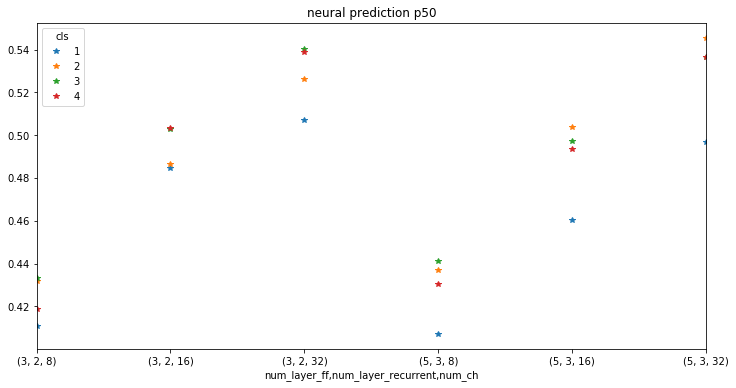

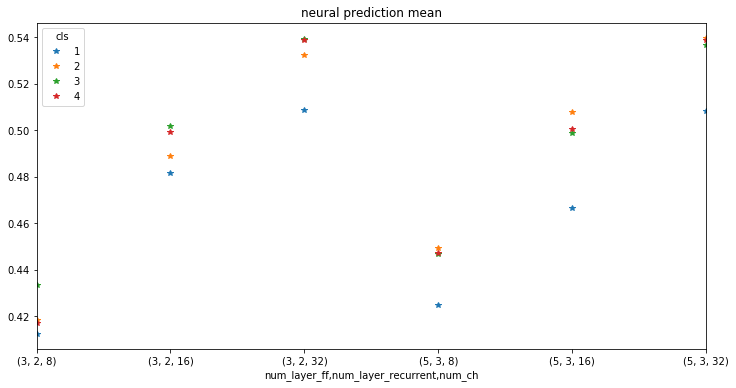

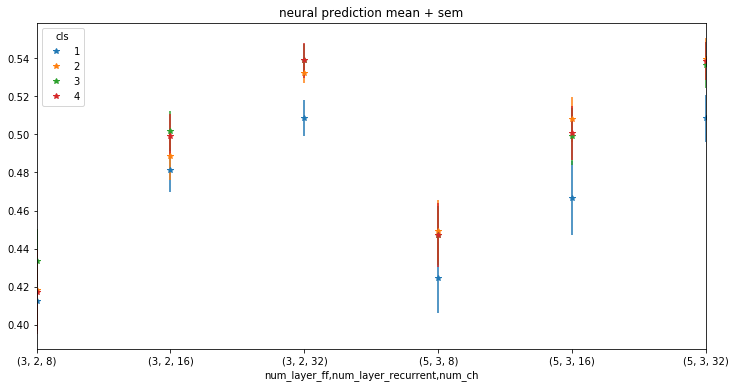

training size 2560
[[ 2  8]
 [ 2 16]
 [ 2 32]
 [ 3  8]
 [ 3 16]
 [ 3 32]
 [ 4  2]
 [ 4  4]
 [ 4  8]
 [ 4 16]
 [ 4 32]
 [ 5  2]
 [ 5  4]
 [ 5  8]
 [ 5 16]
 [ 5 32]
 [ 6  2]
 [ 6  4]
 [ 6  8]
 [ 6 16]
 [ 6 32]]
(168, 2) (144, 2)
2 8
(8, 2)
no matching models!
2 16
(8, 2)
no matching models!
2 32
(8, 2)
no matching models!
3 8
(8, 2)
(24, 2)
[18053. 18045. 18053. 18045. 18053. 18045. 18053. 18045.]
[18053. 18069. 18085. 18045. 18061. 18077. 18053. 18069. 18085. 18045.
 18061. 18077. 18053. 18069. 18085. 18045. 18061. 18077. 18053. 18069.
 18085. 18045. 18061. 18077.]
3 16
(8, 2)
(24, 2)
[22845. 22829. 22845. 22829. 22845. 22829. 22845. 22829.]
[22845. 22877. 22909. 22829. 22861. 22893. 22845. 22877. 22909. 22829.
 22861. 22893. 22845. 22877. 22909. 22829. 22861. 22893. 22845. 22877.
 22909. 22829. 22861. 22893.]
3 32
(8, 2)
(24, 2)
[39341. 39309. 39341. 39309. 39341. 39309. 39341. 39309.]
[39341. 39405. 39469. 39309. 39373. 39437. 39341. 39405. 39469. 39309.
 39373. 39437. 39341. 39405. 3

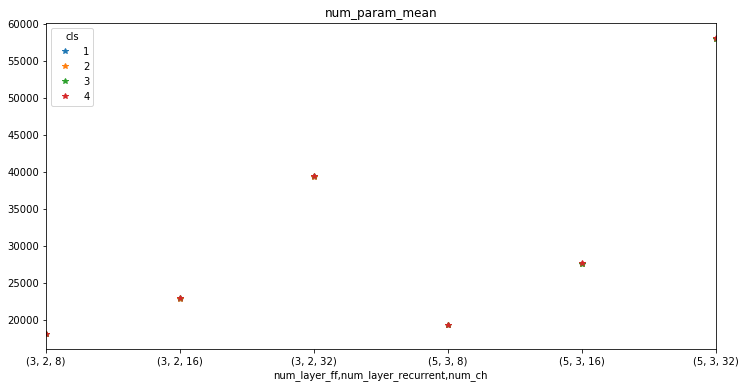

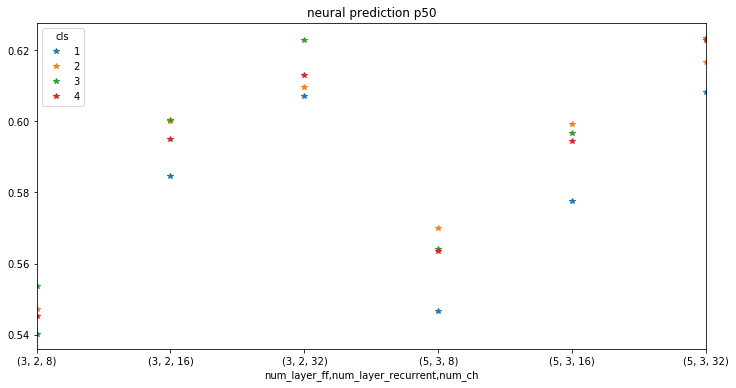

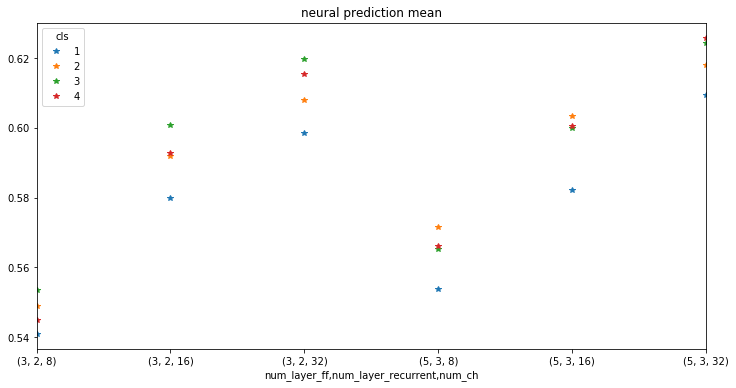

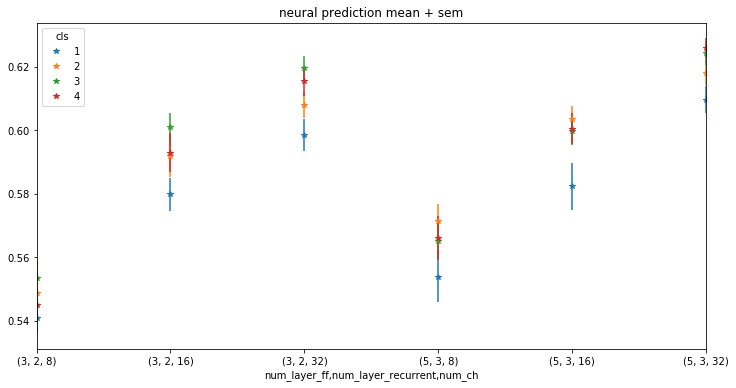

training size 5120
[[ 2  8]
 [ 2 16]
 [ 2 32]
 [ 3  8]
 [ 3 16]
 [ 3 32]
 [ 4  2]
 [ 4  4]
 [ 4  8]
 [ 4 16]
 [ 4 32]
 [ 5  2]
 [ 5  4]
 [ 5  8]
 [ 5 16]
 [ 5 32]
 [ 6  2]
 [ 6  4]
 [ 6  8]
 [ 6 16]
 [ 6 32]]
(168, 2) (144, 2)
2 8
(8, 2)
no matching models!
2 16
(8, 2)
no matching models!
2 32
(8, 2)
no matching models!
3 8
(8, 2)
(24, 2)
[18053. 18045. 18053. 18045. 18053. 18045. 18053. 18045.]
[18053. 18069. 18085. 18045. 18061. 18077. 18053. 18069. 18085. 18045.
 18061. 18077. 18053. 18069. 18085. 18045. 18061. 18077. 18053. 18069.
 18085. 18045. 18061. 18077.]
3 16
(8, 2)
(24, 2)
[22845. 22829. 22845. 22829. 22845. 22829. 22845. 22829.]
[22845. 22877. 22909. 22829. 22861. 22893. 22845. 22877. 22909. 22829.
 22861. 22893. 22845. 22877. 22909. 22829. 22861. 22893. 22845. 22877.
 22909. 22829. 22861. 22893.]
3 32
(8, 2)
(24, 2)
[39341. 39309. 39341. 39309. 39341. 39309. 39341. 39309.]
[39341. 39405. 39469. 39309. 39373. 39437. 39341. 39405. 39469. 39309.
 39373. 39437. 39341. 39405. 3

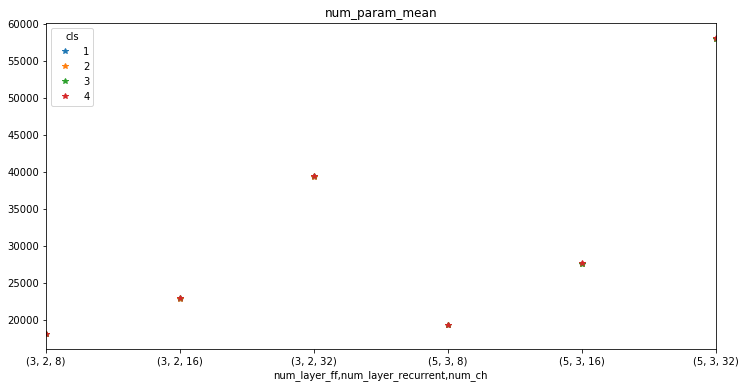

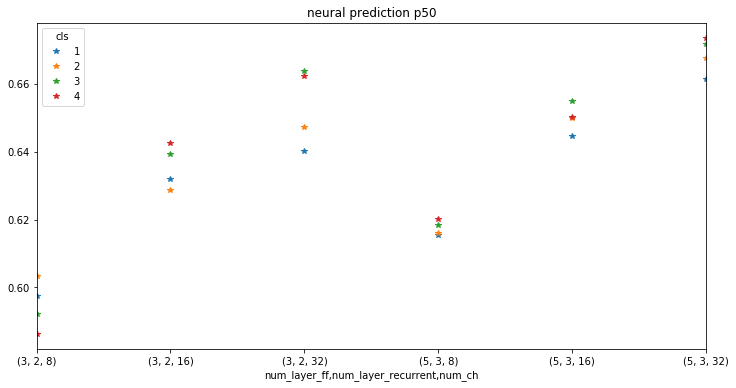

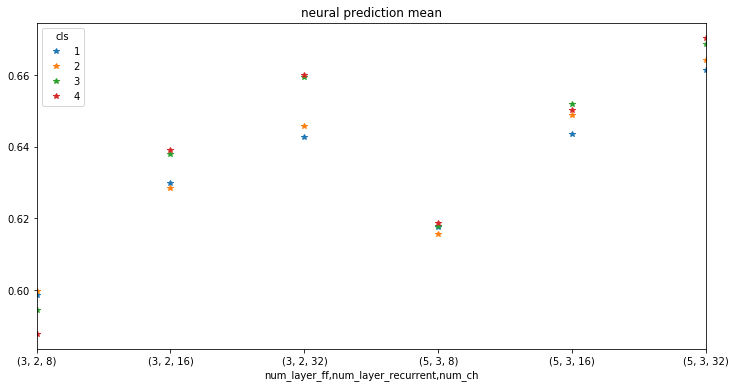

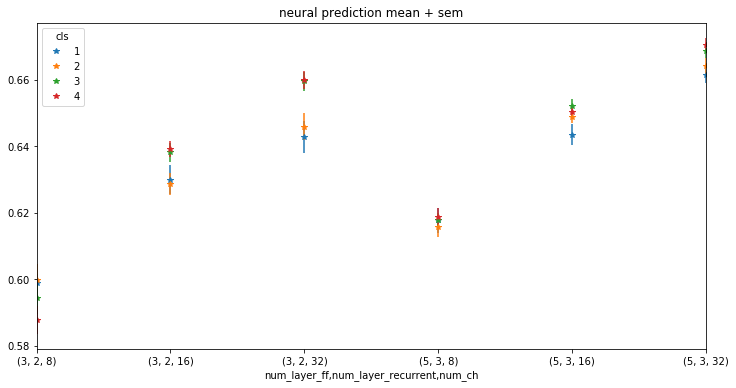

In [18]:
plot_all_quant()